In [1]:
!pip install tensorflow opencv-python matplotlib scikit-learn --quiet
import tensorflow as tf, cv2, matplotlib.pyplot as plt, numpy as np
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"masudurrabby","key":"fcf70459063fd05e7157605645af8d34"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri


Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
  0% 0.00/86.8M [00:00<?, ?B/s]
100% 86.8M/86.8M [00:00<00:00, 1.21GB/s]


In [6]:
!unzip -q brain-tumor-classification-mri.zip -d brain_tumor_dataset


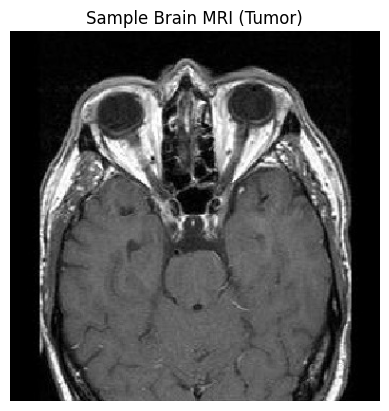

In [7]:
import cv2, matplotlib.pyplot as plt

img = cv2.imread('/content/brain_tumor_dataset/Training/no_tumor/1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Sample Brain MRI (Tumor)')
plt.axis('off')
plt.show()


***Preprocessing & Data Augmentation***

---

## New Section

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

# Set dataset directories
train_dir = '/content/brain_tumor_dataset/Training'
test_dir  = '/content/brain_tumor_dataset/Testing'

# Image settings
IMG_SIZE = (224, 224)   # input size for lightweight CNNs
BATCH_SIZE = 32


In [9]:
# Data generator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalize pixels
    rotation_range=15,        # slight rotation
    width_shift_range=0.1,    # horizontal shift
    height_shift_range=0.1,   # vertical shift
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'       # fill pixels after transform
)

# For testing: only normalization
test_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # 4 classes
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


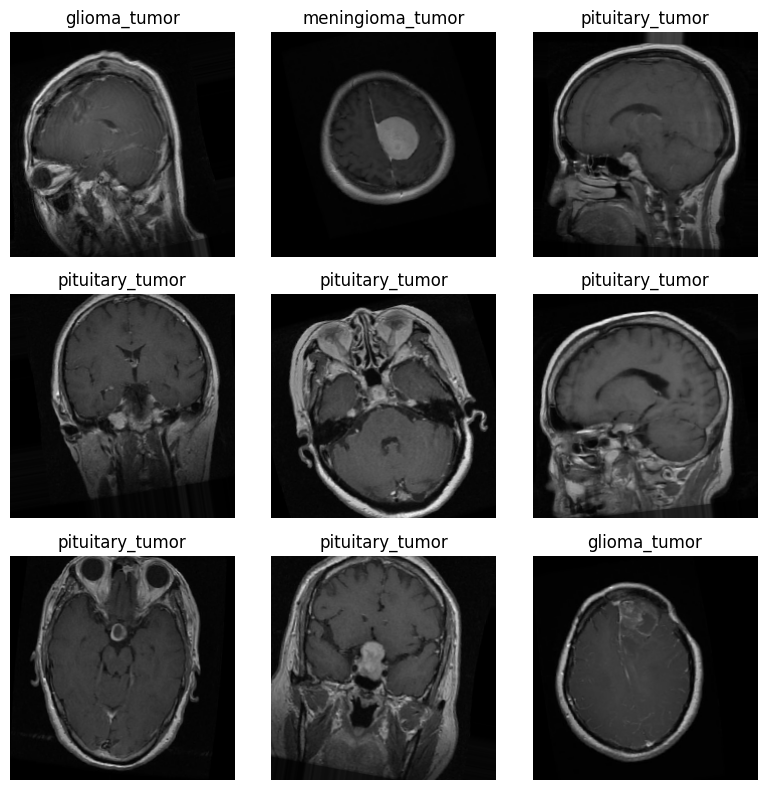

In [11]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    label = np.argmax(y_batch[i])   # get class index
    plt.title(list(train_generator.class_indices.keys())[label])
    plt.axis('off')
plt.tight_layout()
plt.show()


***Model Building & Training (MobileNetV2)***

---

# New Section

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [13]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,          # remove last dense layers
    input_shape=(224, 224, 3)   # same as dataset
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
for layer in base_model.layers:
    layer.trainable = False


In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=predictions)


In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 721ms/step - accuracy: 0.3517 - loss: 1.5028 - val_accuracy: 0.4645 - val_loss: 1.2691
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 423ms/step - accuracy: 0.6198 - loss: 0.9547 - val_accuracy: 0.4721 - val_loss: 1.3215
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 423ms/step - accuracy: 0.6878 - loss: 0.7768 - val_accuracy: 0.4797 - val_loss: 1.3678
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 412ms/step - accuracy: 0.7217 - loss: 0.6968 - val_accuracy: 0.5178 - val_loss: 1.3594
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 419ms/step - accuracy: 0.7475 - loss: 0.6243 - val_accuracy: 0.5000 - val_loss: 1.4472
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 423ms/step - accuracy: 0.7487 - loss: 0.6225 - val_accuracy: 0.5228 - val_loss: 1.4333
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 443ms/step - accuracy: 0.7589 - loss: 0.5920 - val_accuracy: 0.5178 - val_loss: 1.4615
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 428ms/step - accuracy: 0.7759 - loss: 0.5643 - val_accu

In [18]:
for layer in base_model.layers[-30:]:   # unfreeze last 30 layers
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator
)


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 71s 602ms/step - accuracy: 0.4926 - loss: 1.5181 - val_accuracy: 0.6218 - val_loss: 1.3766
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 421ms/step - accuracy: 0.7753 - loss: 0.6038 - val_accuracy: 0.6117 - val_loss: 1.3933
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 417ms/step - accuracy: 0.8171 - loss: 0.4616 - val_accuracy: 0.6244 - val_loss: 1.4047
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 406ms/step - accuracy: 0.8351 - loss: 0.4369 - val_accuracy: 0.6294 - val_loss: 1.4092
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 417ms/step - accuracy: 0.8453 - loss: 0.3932 - val_accuracy: 0.6168 - val_loss: 1.4072


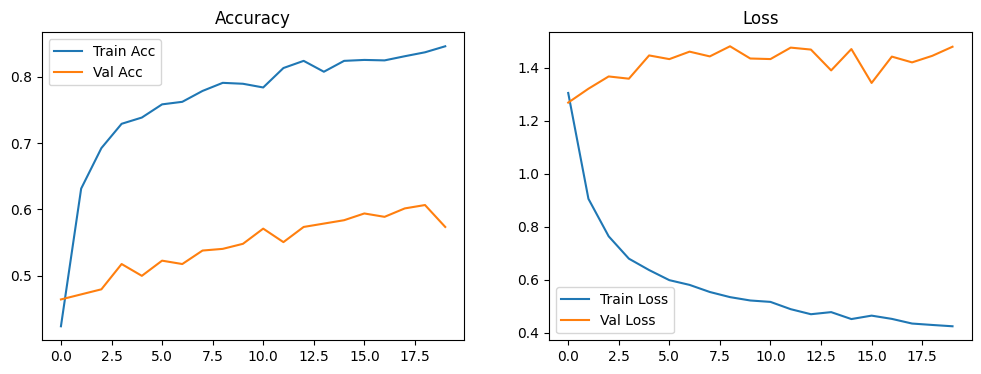

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.show()


In [28]:
model.save('brain_tumor_mobilenetv2.h5')


***Model Evaluation & Performance Testing***

---

# New Section

---



In [20]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4590 - loss: 2.2434
Test Accuracy: 61.68%
Test Loss: 1.4072


In [21]:
# Get true labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Predict probabilities
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step


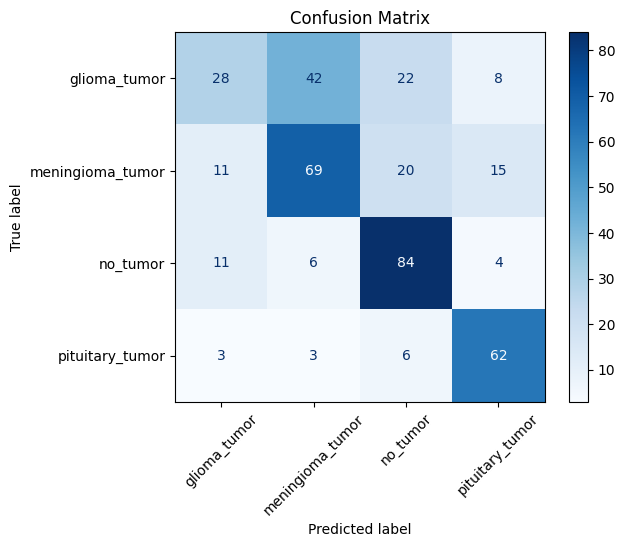

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [23]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_labels))


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.53      0.28      0.37       100
meningioma_tumor       0.57      0.60      0.59       115
        no_tumor       0.64      0.80      0.71       105
 pituitary_tumor       0.70      0.84      0.76        74

        accuracy                           0.62       394
       macro avg       0.61      0.63      0.61       394
    weighted avg       0.60      0.62      0.60       394



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


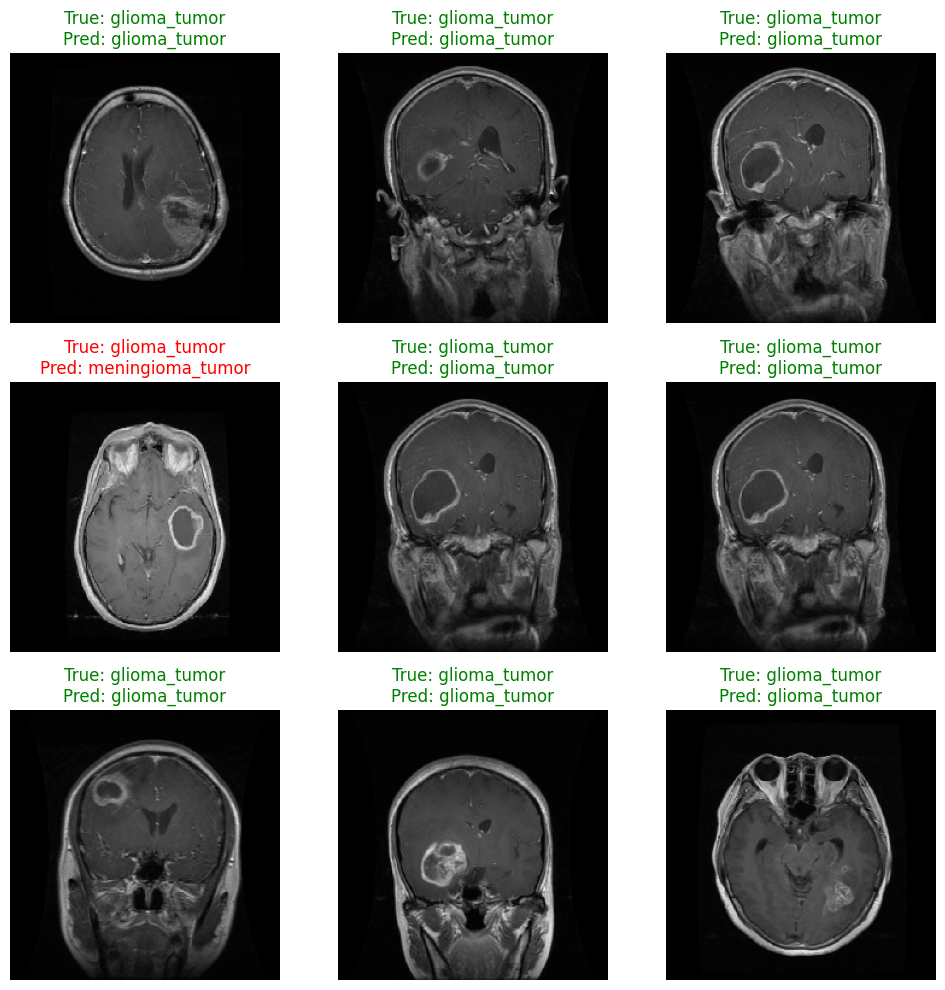

In [26]:
x_batch, y_batch = next(test_generator)

pred_probs = model.predict(x_batch)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_batch, axis=1)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    true_label = class_labels[true_classes[i]]
    pred_label = class_labels[pred_classes[i]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()


***Model Deployment & Real Image Prediction***

---

# New Section

In [29]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/brain_tumor_mobilenetv2.h5')

# Class labels (as before)
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [30]:
from google.colab import files
uploaded = files.upload()


Saving 1.jpg to 1.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


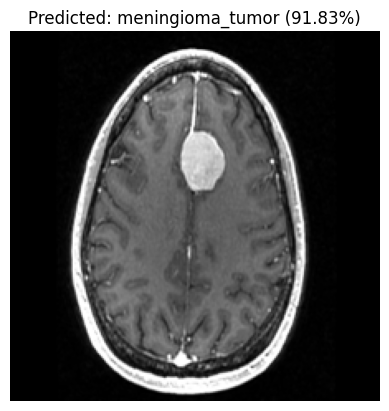

In [31]:
import tensorflow as tf
from PIL import Image

for filename in uploaded.keys():
    # Load and preprocess
    img_path = filename
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)

    # Predict
    predictions = model.predict(img_array)
    pred_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)

    # Display
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[pred_class]} ({confidence*100:.2f}%)")
    plt.show()


In [32]:
!pip install gradio -q
import gradio as gr
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Load model and define class labels
model = load_model('/content/brain_tumor_mobilenetv2.h5')
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

def predict_image(img):
    # Ensure image is PIL
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img.astype('uint8')).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)

    # Predict
    pred = model.predict(img_array)
    pred_class = class_labels[np.argmax(pred)]
    confidence = float(np.max(pred))
    return {pred_class: confidence}

gr.Interface(fn=predict_image, inputs="image", outputs="label").launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://520c85094f9bda6d71.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
